In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from matplotlib import pyplot as plt
from torch.utils.data import Subset
import torch.optim as optim
from torchvision.models import vgg16_bn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
voc_root = "./voc_dataset"
# 下载 Pascal VOC 2012 数据集
voc_train = VOCSegmentation(root=voc_root, year='2012', image_set='train', download=True)
voc_val = VOCSegmentation(root=voc_root, year='2012', image_set='val', download=True)

Using downloaded and verified file: ./voc_dataset\VOCtrainval_11-May-2012.tar
Extracting ./voc_dataset\VOCtrainval_11-May-2012.tar to ./voc_dataset
Using downloaded and verified file: ./voc_dataset\VOCtrainval_11-May-2012.tar
Extracting ./voc_dataset\VOCtrainval_11-May-2012.tar to ./voc_dataset


In [43]:
tfms = Compose([
    Resize((224, 224)),   # 调整图像大小
    ToTensor(),           # 转换为张量
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 使用 ImageNet 的均值和标准差
])
mask_tfms = Resize((224, 224))

In [44]:
class SegData(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        image, mask = self.dataset[ix]
        image = tfms(image)
        mask = torch.tensor(np.array(mask_tfms(mask)), dtype = torch.long)
        mask[mask >= 12] = 255
        return image, mask

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.stack(ims).to(device)
        ce_masks = torch.stack(masks).to(device)
        return ims, ce_masks


In [74]:
train_indices = np.random.choice(len(voc_train), size=200, replace=False)
small_train = Subset(voc_train, train_indices)
val_indices = np.random.choice(len(voc_val), size=50, replace=False)
small_val = Subset(voc_val, val_indices)

trn_ds = SegData(small_train)
val_ds = SegData(small_val)
trn_dl = DataLoader(trn_ds, batch_size=8, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=val_ds.collate_fn)

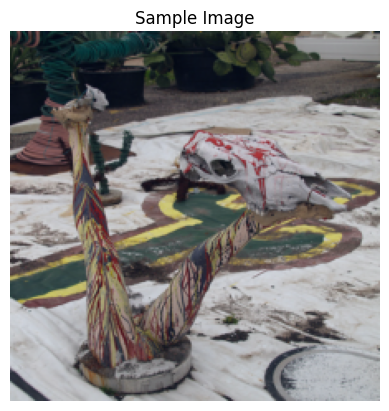

In [75]:
def show(image_tensor, title="Image"):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow((image * 0.229 + 0.485).clip(0, 1))
    plt.title(title)
    plt.axis("off")
    plt.show()

im, mask = trn_ds[10]
show(im, title="Sample Image")

In [76]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [77]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [78]:
class UNet(nn.Module):
    def __init__(self, pretrained = True, out_channels = 12):
        super().__init__()
        self.encoder = vgg16_bn(pretrained = pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        # Dropout layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv_bottleneck = conv(512, 256)
        self.dropout_bottleneck = nn.Dropout(0.3)

        self.up_conv6 = up_conv(256, 128)
        self.conv6 = conv(128 + 512, 128)

        self.up_conv7 = up_conv(128, 64)
        self.conv7 = conv(64 + 256, 64)

        self.up_conv8 = up_conv(64, 32)
        self.conv8 = conv(32 + 128, 32)

        self.up_conv9 = up_conv(32, 32)
        self.conv9 = nn.Conv2d(32, out_channels, kernel_size = 1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.conv_bottleneck(block5)
        bottleneck = self.dropout_bottleneck(bottleneck)

        x = self.up_conv6(bottleneck)
        x = torch.cat([x, block4], dim = 1)
        x = self.conv6(x)
        x = self.dropout1(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block3], dim = 1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block2], dim = 1)
        x = self.conv8(x)
        x = self.dropout2(x)
        x = self.up_conv9(x)
        x = self.conv9(x)

        return x

In [79]:
ce = nn.CrossEntropyLoss(ignore_index=255)
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [80]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [81]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

In [82]:
history = {
    "trn_loss": [],
    "trn_acc": [],
    "val_loss": [],
    "val_acc": []
}

for ex in range(n_epochs):
    print(f"Epoch {ex + 1}/{n_epochs}")
    
    trn_loss, trn_acc = 0.0, 0.0
    val_loss, val_acc = 0.0, 0.0

    for data in trn_dl:
        loss, acc = train_batch(model, data, optimizer, criterion)
        trn_loss += loss
        trn_acc += acc

    for data in val_dl:
        loss, acc = validate_batch(model, data, criterion)
        val_loss += loss
        val_acc += acc

    avg_trn_loss = trn_loss / len(trn_dl)
    avg_trn_acc = trn_acc / len(trn_dl)
    avg_val_loss = val_loss / len(val_dl)
    avg_val_acc = val_acc / len(val_dl)

    history["trn_loss"].append(avg_trn_loss)
    history["trn_acc"].append(avg_trn_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(avg_val_acc)

    print(f"  Train Loss: {avg_trn_loss:.4f}, Train Acc: {avg_trn_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

Epoch 1/20
  Train Loss: 2.4707, Train Acc: 0.0506
  Val Loss: 2.4982, Val Acc: 0.0221
Epoch 2/20
  Train Loss: 2.3713, Train Acc: 0.2059
  Val Loss: 2.2991, Val Acc: 0.3708
Epoch 3/20
  Train Loss: 2.2621, Train Acc: 0.4050
  Val Loss: 2.2331, Val Acc: 0.4384
Epoch 4/20
  Train Loss: 2.1345, Train Acc: 0.5422
  Val Loss: 1.8965, Val Acc: 0.6751
Epoch 5/20
  Train Loss: 1.9909, Train Acc: 0.5977
  Val Loss: 1.7829, Val Acc: 0.6781
Epoch 6/20
  Train Loss: 1.8329, Train Acc: 0.6361
  Val Loss: 1.6783, Val Acc: 0.6514
Epoch 7/20
  Train Loss: 1.6655, Train Acc: 0.6516
  Val Loss: 1.6229, Val Acc: 0.6267
Epoch 8/20
  Train Loss: 1.4985, Train Acc: 0.6637
  Val Loss: 1.3883, Val Acc: 0.6702
Epoch 9/20
  Train Loss: 1.3261, Train Acc: 0.6711
  Val Loss: 1.0951, Val Acc: 0.6990
Epoch 10/20
  Train Loss: 1.1721, Train Acc: 0.6769
  Val Loss: 1.0166, Val Acc: 0.6948
Epoch 11/20
  Train Loss: 1.0312, Train Acc: 0.6868
  Val Loss: 0.9278, Val Acc: 0.6924
Epoch 12/20
  Train Loss: 0.9210, Train A

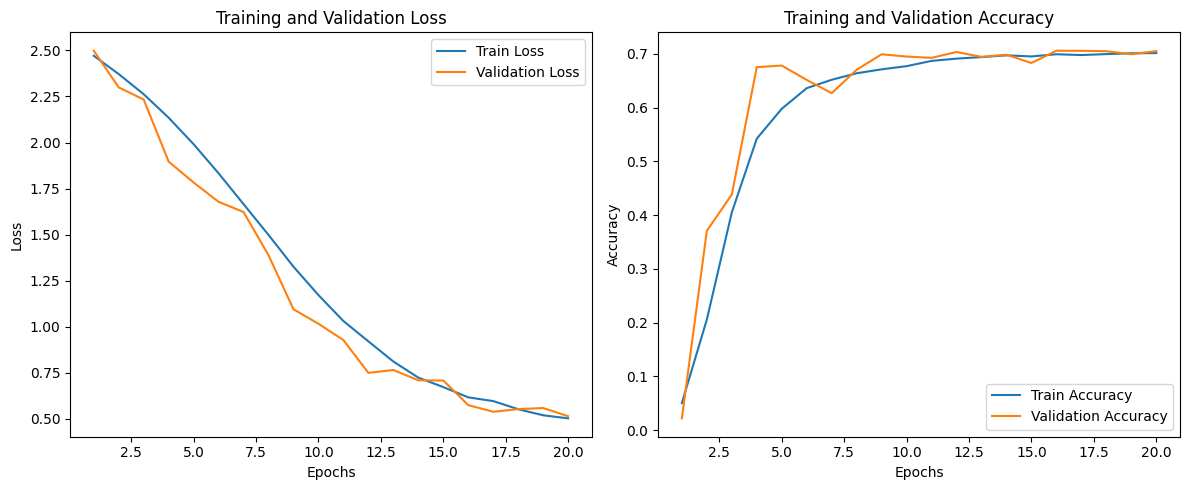

In [83]:
epochs = range(1, n_epochs + 1)
plt.figure(figsize=(12, 5))

# 损失图
plt.subplot(1, 2, 1)
plt.plot(epochs, history["trn_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# 准确率图
plt.subplot(1, 2, 2)
plt.plot(epochs, history["trn_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

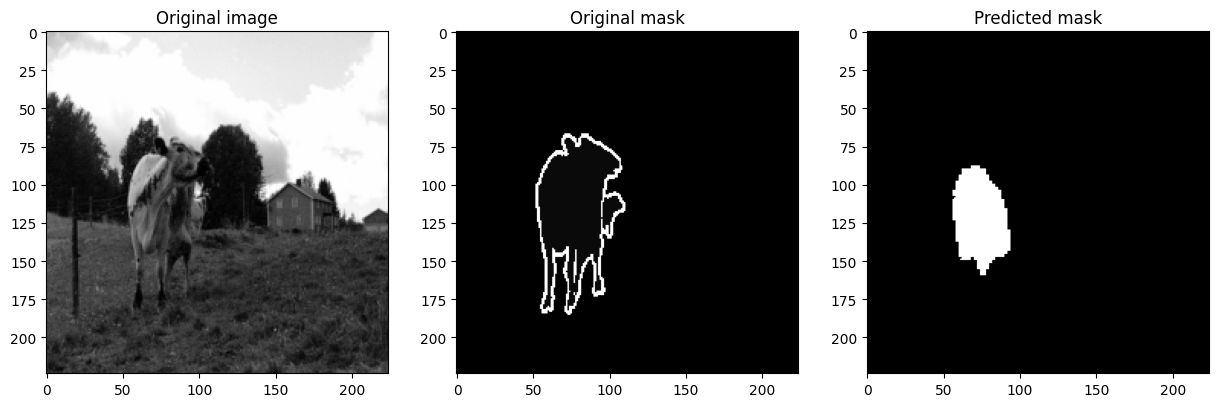

In [84]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(mask.permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')
axs[1].set_title('Original mask')
axs[2].imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')
axs[2].set_title('Predicted mask')
plt.show()